In [22]:
import os
import glob 
from functools import reduce

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6) 
plt.rcParams['font.size'] = 14

In [24]:
results_dir = "../../../../../../../results/"
run_name = "timeseries/time-varying/3_X_max/single-backend/500ms/10mins-run/feedback-wlc/2nd-seed-run"

## Client side stats

In [25]:
# read in the data
plot_data_list = []

for i in glob.glob(results_dir + run_name + "/httperf_client_*.csv"):
    plot_data_list.append(pd.read_csv(i, header=0, na_filter=False))

In [26]:
plot_data = pd.DataFrame()

if len(plot_data_list) > 0:
    for i in list(plot_data_list[0]):
        if not i.startswith('Response time'):
            plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] for j in range(len(plot_data_list))])
        else:
            plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] 
                                                       for j in range(len(plot_data_list))]) / len(plot_data_list)

plot_data.head()

,Response time 66%,Response status 4xx,Response rate 99%,Response time 50%,Response time 99%,Response rate 66%,Response rate 75%,Response time,Number of requests,Response rate 90%,...,Response rate 98%,Response time 98%,Request rate,Response time 90%,Response status 5xx,Response status 2xx,Response time 80%,Response rate 50%,Rate,Response rate 95%
0,16.625,0,192.0,14.5,100.375,184.0,184.0,18.75,115200,184.0,...,192.0,40.625,192.0,24.625,0,115200,19.625,184.0,192,188.0


### 1. Request rate

In [27]:
rr_plot_data = plot_data[['Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%',
                          'Response rate 80%', 'Response rate 90%', 'Response rate 95%', 'Response rate 98%',
                          'Response rate 99%', 'Response rate 100%']]
rr_plot_data

,Request rate,Response rate 50%,Response rate 66%,Response rate 75%,Response rate 80%,Response rate 90%,Response rate 95%,Response rate 98%,Response rate 99%,Response rate 100%
0,192.0,184.0,184.0,184.0,184.0,184.0,188.0,192.0,192.0,203.0


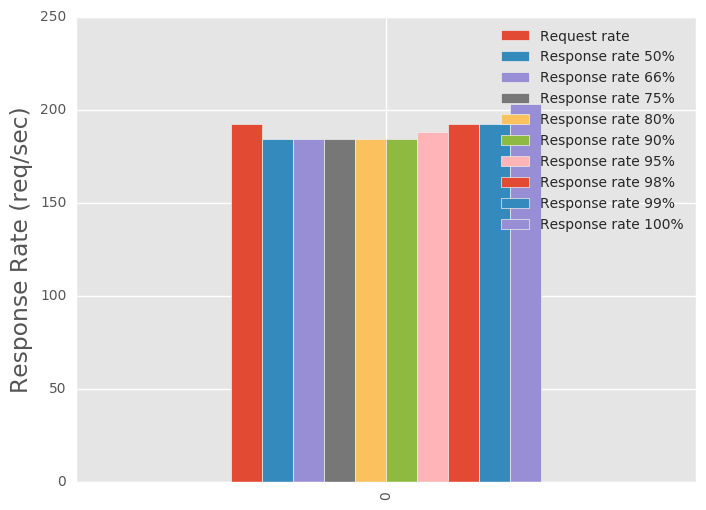

In [28]:
rr_plot_data.plot(ylim=(0, None), kind='bar').set_ylabel("Response Rate (req/sec)")

In [29]:
rr_plot_data.to_csv(results_dir + run_name + "/response_rate.csv")

### 1. Request time

In [30]:
rt_plot_data = plot_data[['Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%',
                          'Response time 80%', 'Response time 90%', 'Response time 95%', 'Response time 98%',
                          'Response time 99%', 'Response time 100%']]
rt_plot_data

,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,18.75,14.5,16.625,18.5,19.625,24.625,30.5,40.625,100.375,419.25


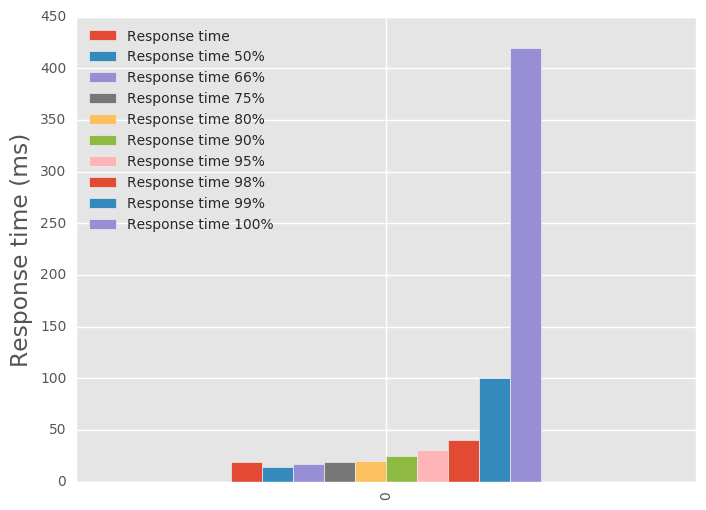

In [31]:
rt_plot_data.plot(ylim=(0, None), kind='bar').set_ylabel("Response time (ms)")

In [32]:
rt_plot_data.to_csv(results_dir + run_name + "/response_time.csv")

### 3. Success rate

In [33]:
sr_plot_data = (plot_data['Response status 2xx'] + plot_data['Response status 3xx']) / plot_data['Number of requests'] * 100.0
sr_plot_data

0    100.0
dtype: float64

## Timeseries analysis

In [34]:
ts_data_dict = {}

for i in glob.glob(results_dir + run_name + "/lb_server_*.csv"):
    ts_data_dict[os.path.basename(i)] = pd.read_csv(i, header=0, na_filter=False)
    
ts_data_dict.keys()

dict_keys(['lb_server_116.csv', 'lb_server_stats_116.csv'])

### 1st stats

In [35]:
ts_data_dict['lb_server_116.csv'].head()

,11.11.11.112:ActiveConn,11.11.11.114:InActConn,11.11.11.112:InActConn,11.11.11.115:InActConn,11.11.11.114:ActiveConn,11.11.11.113:ActiveConn,11.11.11.115:ActiveConn,11.11.11.113:Weight,11.11.11.113:InActConn,11.11.11.112:Weight,11.11.11.114:Weight,11.11.11.115:Weight
0,0,0,0,0,0,0,0,99,0,99,99,99
1,0,0,0,0,0,0,0,99,0,53,99,99
2,0,0,0,0,0,0,0,99,0,53,99,99
3,0,0,0,0,0,0,0,99,0,53,99,99
4,0,0,0,0,0,0,0,99,0,53,99,99


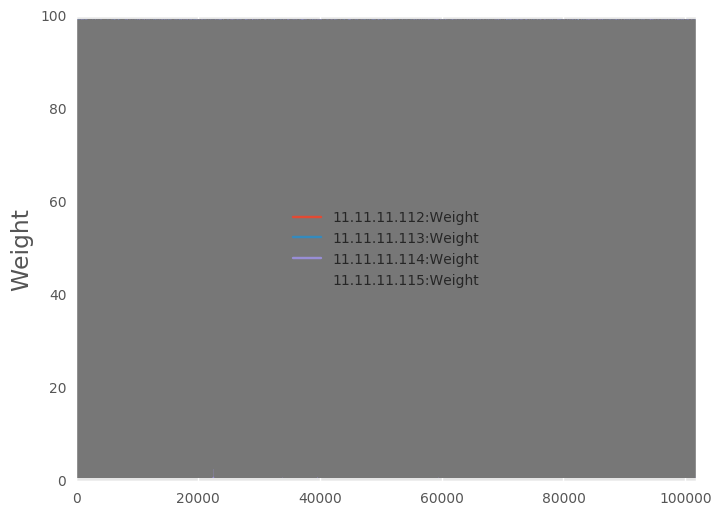

In [36]:
wt_data = pd.DataFrame()

wt_data = ts_data_dict['lb_server_116.csv'][['11.11.11.112:Weight',
                                             '11.11.11.113:Weight',
                                             '11.11.11.114:Weight',
                                             '11.11.11.115:Weight']]

wt_data.plot(ylim=(0, None)).set_ylabel("Weight")

In [37]:
wt_data.mean()

11.11.11.112:Weight    24.476284
11.11.11.113:Weight    56.548686
11.11.11.114:Weight    56.169184
11.11.11.115:Weight    58.612676
dtype: float64

#### Active Conns

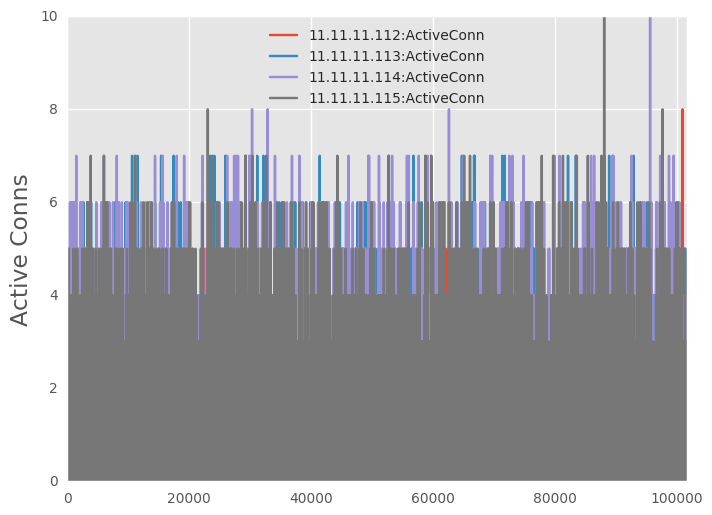

In [38]:
ac_data = pd.DataFrame()

ac_data = ts_data_dict['lb_server_116.csv'][['11.11.11.112:ActiveConn',
                                             '11.11.11.113:ActiveConn',
                                             '11.11.11.114:ActiveConn',
                                             '11.11.11.115:ActiveConn']]

ac_data.plot(ylim=(0, None)).set_ylabel("Active Conns")

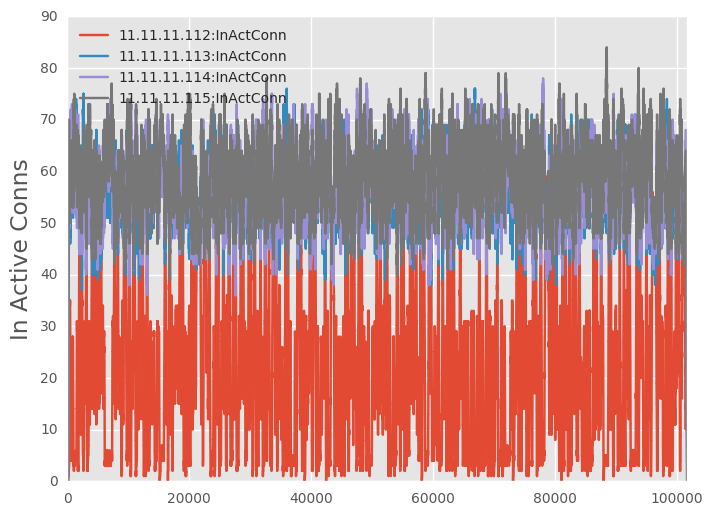

In [39]:
iac_data = pd.DataFrame()

iac_data = ts_data_dict['lb_server_116.csv'][['11.11.11.112:InActConn',
                                              '11.11.11.113:InActConn',
                                              '11.11.11.114:InActConn',
                                              '11.11.11.115:InActConn']]

iac_data.plot(ylim=(0, None)).set_ylabel("In Active Conns")

### 2nd Stats

In [40]:
ts_data_dict['lb_server_stats_116.csv'].head()

,11.11.11.113:InBytes,172.16.116.116:InBytes,11.11.11.115:OutPkts,11.11.11.113:InPkts,11.11.11.112:OutBytes,11.11.11.113:Conns,11.11.11.115:Conns,11.11.11.114:InBytes,172.16.116.116:OutBytes,11.11.11.113:OutBytes,...,11.11.11.114:Conns,11.11.11.114:InPkts,11.11.11.112:InPkts,11.11.11.112:Conns,11.11.11.113:OutPkts,11.11.11.114:OutBytes,11.11.11.115:OutBytes,11.11.11.112:OutPkts,11.11.11.114:OutPkts,172.16.116.116:OutPkts
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


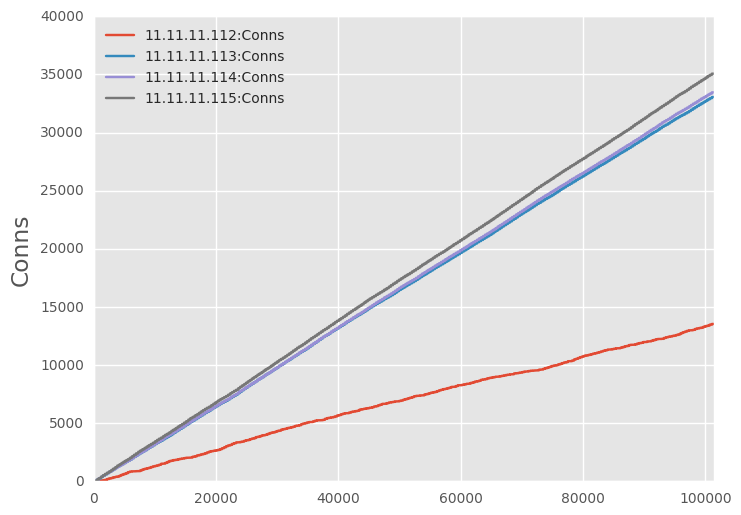

In [41]:
cn_data = pd.DataFrame()

cn_data = ts_data_dict['lb_server_stats_116.csv'][['11.11.11.112:Conns',
                                                   '11.11.11.113:Conns',
                                                   '11.11.11.114:Conns',
                                                   '11.11.11.115:Conns']]

cn_data.plot(ylim=(0, None)).set_ylabel("Conns")

In [42]:
cn_data[['11.11.11.112:Conns',
         '11.11.11.113:Conns',
         '11.11.11.114:Conns',
         '11.11.11.115:Conns']].tail(1)

,11.11.11.112:Conns,11.11.11.113:Conns,11.11.11.114:Conns,11.11.11.115:Conns
101326,13532,33052,33454,35062


## Configurations

X_max rate: 24 req/sec. For this run we used: 3 * X_max.

```json
{
  "env": {
    "warn_only": true,
    "hosts": [
      "root@128.112.168.27",
      "root@128.112.168.28"
    ],
    "roledefs": {
      "server": [
        "root@128.112.168.27"
      ],
      "analyst": [
        "root@128.112.168.28"
      ]
    },
    "user": "root",
    "password": "PrincetonP4OVS",
    "vm": {
      "prefix": "10.10.10.",
      "user": "mshahbaz",
      "password": "nopass"
    },
    "analyst": {
      "path": "/root/mshahbaz/notebooks/baseerat/runs"
    }
  },
  "httperf_ipvs_lb": {
    "vm": {
      "base_id": 103,
      "prefix_1": "11.11.11.",
      "@Shahbaz": "prefix_1 requires that a second bridge 'vmbr1' is setup on the proxmox host."
    },
    "vip": {
      "prefix": "172.16."
    },
    "feedback": {
      "enable": true,
      "is_dummy": false,
      "@Shahbaz": "is_dummy is to generate equal load on the backends when running WLC"
    },
    "stats":{
      "enable": true
    },
    "servers": {
      "web_server": {
        "options": {
          "sockets": 1,
          "cores": 2,
          "memory": 4096
        },
        "vms": [
          {
            "vm_id": 112,
            "lb_server": 0,
            "webpage": {
              "cgi": {
                "enable": true,
                "loop_count": 1
              }
            },
            "load": {
              "enable": true,
              "type": "cpulimit",
              "#type": "nice",
              "types": {
                "cpulimit": {
                  "percentage": 4
                },
                "nice": {
                  "value": 20
                }
              },
              "process_count": 38,
              "seed_value": 2,
              "time_variance": 0.5
            },
            "state_server": {
              "id": 0,
              "timeout": 0.001,
              "metric": "cpu",
              "#metric": "loadavg",
              "metrics": {
                "cpu": {
                  "alpha_value": 0.5
                },
                "loadavg": {
                  "max_load": 5
                }
              }
            }
          },
          {
            "vm_id": 113,
            "lb_server": 0,
            "webpage": {
              "cgi": {
                "enable": true,
                "loop_count": 1
              }
            },
            "load": {
              "enable": true,
              "type": "cpulimit",
              "#type": "nice",
              "types": {
                "cpulimit": {
                  "percentage": 4
                },
                "nice": {
                  "value": 20
                }
              },
              "process_count": 38,
              "seed_value": 22,
              "time_variance": 0.5
            },
            "state_server": {
              "id": 0,
              "timeout": 0.001,
              "metric": "cpu",
              "#metric": "loadavg",
              "metrics": {
                "cpu": {
                  "alpha_value": 0.5
                },
                "loadavg": {
                  "max_load": 5
                }
              }
            }
          },
          {
            "vm_id": 114,
            "lb_server": 0,
            "webpage": {
              "cgi": {
                "enable": true,
                "loop_count": 1
              }
            },
            "load": {
              "enable": true,
              "type": "cpulimit",
              "#type": "nice",
              "types": {
                "cpulimit": {
                  "percentage": 4
                },
                "nice": {
                  "value": 20
                }
              },
              "process_count": 38,
              "seed_value": 222,
              "time_variance": 0.5
            },
            "state_server": {
              "id": 0,
              "timeout": 0.001,
              "metric": "cpu",
              "#metric": "loadavg",
              "metrics": {
                "cpu": {
                  "alpha_value": 0.5
                },
                "loadavg": {
                  "max_load": 5
                }
              }
            }
          },
          {
            "vm_id": 115,
            "lb_server": 0,
            "webpage": {
              "cgi": {
                "enable": true,
                "loop_count": 1
              }
            },
            "load": {
              "enable": true,
              "type": "cpulimit",
              "#type": "nice",
              "types": {
                "cpulimit": {
                  "percentage": 4
                },
                "nice": {
                  "value": 20
                }
              },
              "process_count": 38,
              "seed_value": 2222,
              "time_variance": 0.5
            },
            "state_server": {
              "id": 0,
              "timeout": 0.001,
              "metric": "cpu",
              "#metric": "loadavg",
              "metrics": {
                "cpu": {
                  "alpha_value": 0.5
                },
                "loadavg": {
                  "max_load": 5
                }
              }
            }
          }
        ]
      },
      "state_server": {
        "options": {
          "sockets": 1,
          "cores": 1,
          "memory": 1024
        },
        "vms": [
          {
            "vm_id": 116
          }
        ]
      },
      "lb_server": {
        "options": {
          "sockets": 1,
          "cores": 2,
          "memory": 4096
        },
        "vms": [
          {
            "vm_id": 116,
            "web_servers": [
              0,
              1,
              2,
              3
            ],
            "lb": {
              "policy": "wlc",
              "fin_timeout": 1
            },
            "state_server": {
              "id": 0,
              "timeout": 0.001
            },
            "stats": {
              "timeout": 0.001
            }
          }
        ]
      },
      "httperf_client": {
        "options": {
          "sockets": 1,
          "cores": 1,
          "memory": 2048
        },
        "config": {
          "num_conns": 14400,
          "num_calls": 1,
          "rate": 24,
          "ramp": 10,
          "iters": 1,
          "timeout": 50
        },
        "vms": [
          {
            "vm_id": 120,
            "lb_server": 0
          },
          {
            "vm_id": 121,
            "lb_server": 0
          },
          {
            "vm_id": 122,
            "lb_server": 0
          },
          {
            "vm_id": 123,
            "lb_server": 0
          },
          {
            "vm_id": 124,
            "lb_server": 0
          },
          {
            "vm_id": 125,
            "lb_server": 0
          },
          {
            "vm_id": 126,
            "lb_server": 0
          },
          {
            "vm_id": 127,
            "lb_server": 0
          }
        ]
      }
    }
  }
}
```